In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

# Load your data
df1 = pd.read_csv(r'C:\Users\lenovo\Documents\archive\Orders.csv')
df2 = pd.read_csv(r'C:\Users\lenovo\Documents\archive\Details.csv')

# Merge
df = pd.merge(df1, df2, on='Order ID', how='inner')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y', errors='coerce')

Clothing - Initial rules: 749
Clothing - Simple rules (single antecedent/consequent): 72
Clothing - After deduplication: 36


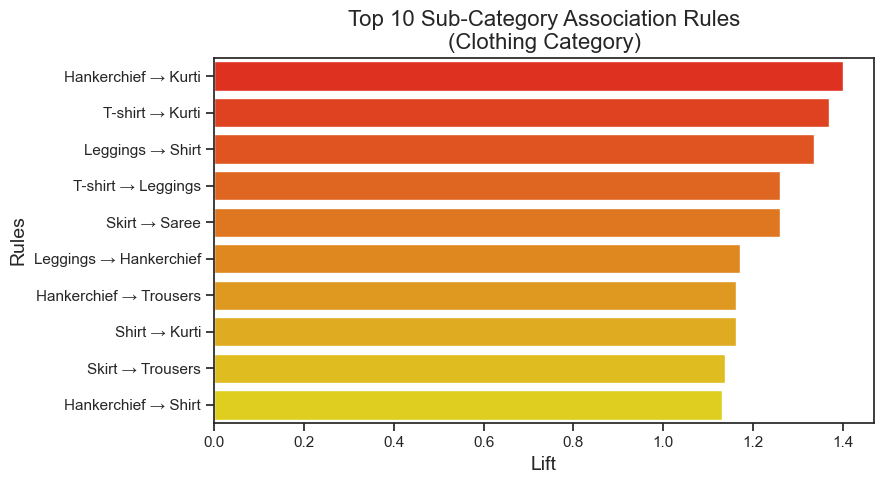

Electronics - Initial rules: 27
Electronics - Simple rules (single antecedent/consequent): 12
Electronics - After deduplication: 6


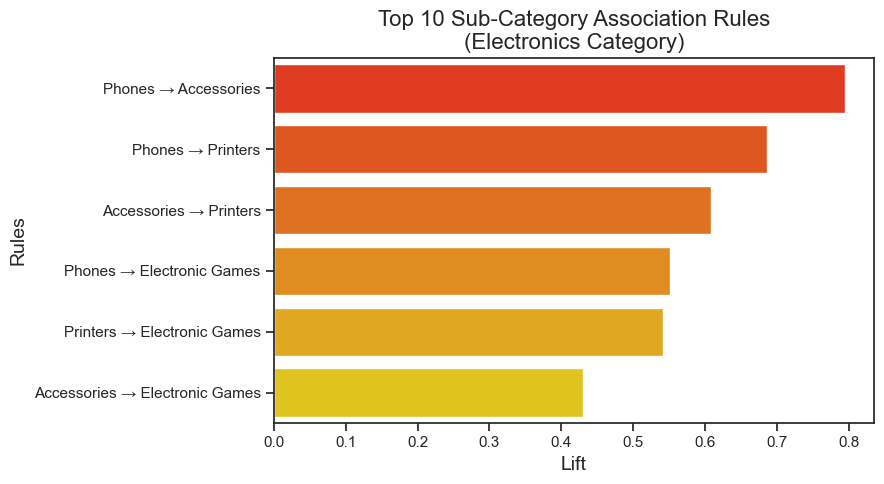

Furniture - Initial rules: 24
Furniture - Simple rules (single antecedent/consequent): 10
Furniture - After deduplication: 6


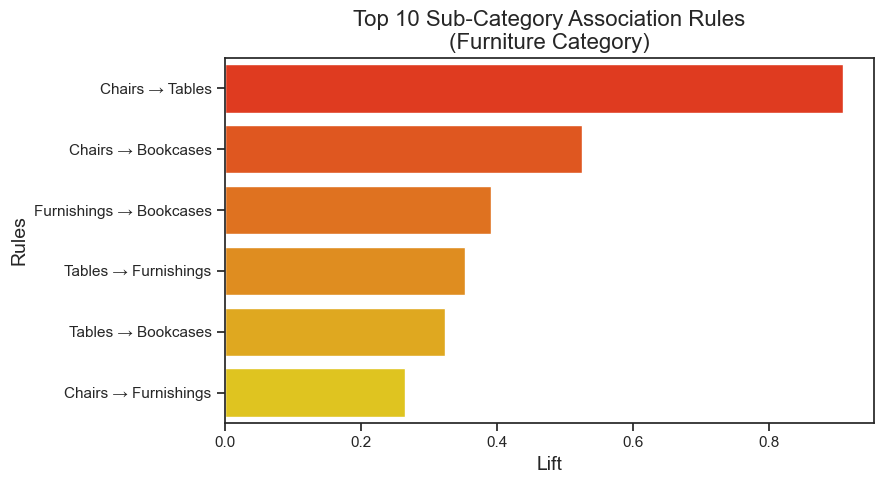

In [50]:
def plot_association_rules(df, category, save_path=None, show=True):
    df_cat = df[df['Category'] == category]
    if df_cat.empty:
        print(f"No data for category: {category}")
        return

    basket = df_cat.pivot_table(
        index='Order ID',
        columns='Sub-Category',
        values='Quantity',
        aggfunc='sum',
        fill_value=0
    )
    basket = basket > 0

    frequent_itemsets = apriori(basket, min_support=0.005, use_colnames=True)  # Lowered support
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)  # Lowered threshold
    print(f"{category} - Initial rules: {len(rules)}")
    
    simple_rules = rules[
        (rules['antecedents'].apply(lambda x: len(x) == 1)) &
        (rules['consequents'].apply(lambda x: len(x) == 1))
    ]
    print(f"{category} - Simple rules (single antecedent/consequent): {len(simple_rules)}")
    top_rules = simple_rules.sort_values('lift', ascending=False)

    # Deduplicate by sorted pair (ignore direction)
    def format_itemset(itemset):
        return ", ".join(sorted(str(i) for i in itemset))

    top_rules['pair'] = [
        " & ".join(sorted([
            format_itemset(row['antecedents']), 
            format_itemset(row['consequents'])
        ]))
        for _, row in top_rules.iterrows()
    ]

    top_rules = top_rules.drop_duplicates(subset=['pair'])
    print(f"{category} - After deduplication: {len(top_rules)}")
    top_rules = top_rules.head(10)

    if top_rules.empty:
        print(f"No strong association rules for category: {category}")
        return

    def label_rule(row):
        return f"{format_itemset(row['antecedents'])} → {format_itemset(row['consequents'])}"
    
    labels = [label_rule(row) for _, row in top_rules.iterrows()]
    lift_values = top_rules['lift'].tolist()

    plt.figure(figsize=(9, 5))
    sns.barplot(x=lift_values, y=labels, palette="autumn")
    plt.xlabel("Lift", fontsize=14)
    plt.ylabel("Rules", fontsize=14)
    plt.title(f"Top 10 Sub-Category Association Rules\n({category} Category)", fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

# Call the function for each category!
categories = ['Clothing', 'Electronics', 'Furniture']
for cat in categories:
    plot_association_rules(df, cat)